### 내용
  - 영화 리뷰(review) 텍스트를 긍정(positive) / 부정(negative)로 분류
  - 이진(binary) 분류 : 클래스(class)가 두 개인 분류  
    
### 데이터
  - 인터넷 영화 데이터베이스(Internet Movie Database) : 50,000개
  - IMDB 데이터셋 사용
  - 구성 : (train, test) = (25000, 25000)

### 01. import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

In [2]:
print(tf.__version__)

2.5.0


### 02. IMDB Dataset Download
  - 리뷰는 전처리해서 정수 시퀀스로 변환되어 있음
  - 정수 : 어휘사전에 있는 특정 단어  
    
  - num_words=10000 : 가장 많이 등장하는 상위 10,000개의 단어를 선택

In [3]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 2s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\jjanh_000\program\conda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\jjanh_000\program\conda\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

### 03. 데이터 확인

In [4]:
print("train: {}, label: {}".format(len(train_data), len(train_labels)))

train: 25000, label: 25000


In [6]:
print(train_data[0])
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

#### 정수를 단어로 변환

In [8]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 이미 정의되어 있는 인덱스 : 의미있는 단어가 아니라 텍스트에 필요한 인덱스
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2    # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 1s 0us/step


#### decode_review 함수 : 리뷰 텍스트를 출력

In [9]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 04. 데이터 준비
  - 원-핫 인코딩(one-hot encoding) : 0과 1로 이루어진 정수 배열 벡터
    - 10,000차원의 벡터 중 요소가 1인 인자만 배열로 나타냄
    - num_words * num_reviews 크기의 행렬이 필요 : 메모리 사용량 크다
    - Dense 층을 신경망의 첫 번째 층으로 사용 : 실수 벡터 데이터를 다루는 층
      
  - 패딩(padding)을 추가해 정수 배열의 길이를 일치
    - max_length * num_reviews 크기의 정수 텐서
    - 이 텐서를 다룰 수 있는 임베딩(embedding) 층을 신경망의 첫 번째 층으로 사용

#### pad_sequences 함수 : 영화리뷰의 길이를 같도록 만듬

In [10]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)

In [11]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [12]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### 05. 모델 구성
  - 모델에서 얼마나 많은 층을 사용할 것인가?
  - 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?  
    
    
  - 입력 데이터 : 단어 인덱스의 배열
  - 예측 레이블 : positive / negative  
    
      
#### layer 구성 : 분류기(classifier)
  - Embedding
    - 입력 : 정수로 인코딩된 단어
    - 각 단어 인덱스에 해당하는 임베딩 벡터 : 모델이 훈련되면서 학습
    - 출력(최종) 차원 : (batch, sequence, embedding)
  - GlobalAveragePooling1D
    - sequence 차원에 대해 평균을 계산
    - 각 샘플에 고정된 길이의 출력 벡터를 반환 : 길이가 다른 입력을 다루는 가장 간단한 방법
  - Dense : 16개의 은닉 유닛을 가진 fully-connected 층을 거침
  - 마지막 층 : 하나의 출력 노드를 가진 fully-connected 층
    - 활성화 함수 : sigmoid를 통해 0과 1사이의 실수를 출력
    - 출력된 값은 확률 또는 신뢰도를 나타냄

In [13]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#### 은닉 유닛 : hidden unit
  - 입력과 출력 사이에 은닉 층이 존재.
  - 출력(유닛, 노드, 뉴런)의 개수는 층이 가진 표현공간(representational space)의 차원
    - 내부 표현을 학습할 때 허용되는 네트워크의 자유도의 양  
      
  - 유닛이 많으면
    - 네트워크는 더 복잡한 표현을 학습
    - 계산비용이 많이 들고 원치않는 패턴도 학습
    - overfitting : 훈련데이터의 성능을 향상시키지만 테스트에서는 그렇지 못한 상황이 발생할 수 있음

#### 손실함수
  - 손실함수(loss function)
    - binary_crossentropy
      - 확률을 다루는 데 적합
      - 확률분포 간의 거리를 측정 : 정답인 타깃 분포화 예측 분포 사이의 거리
    - mean_squared_error : 회귀(regression) 문제에 적합

In [14]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

### 06. 검증 셋 만들기 : validation set
  - 테스트 전 데이터에서 정확도를 확인
  - 10000개의 검증 데이터 셋

In [15]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 07. 모델 훈련
  - mini_batch : 512
  - epoch : 40(반복)

In [16]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/40
30/30 [==============================] - 9s 93ms/step - loss: 0.6921 - accuracy: 0.5557 - val_loss: 0.6902 - val_accuracy: 0.7138
Epoch 2/40
30/30 [==============================] - 2s 67ms/step - loss: 0.6870 - accuracy: 0.7240 - val_loss: 0.6830 - val_accuracy: 0.7136
Epoch 3/40
30/30 [==============================] - 2s 67ms/step - loss: 0.6754 - accuracy: 0.7553 - val_loss: 0.6683 - val_accuracy: 0.7535
Epoch 4/40
30/30 [==============================] - 2s 68ms/step - loss: 0.6543 - accuracy: 0.7734 - val_loss: 0.6441 - val_accuracy: 0.7640
Epoch 5/40
30/30 [==============================] - 2s 67ms/step - loss: 0.6229 - accuracy: 0.7893 - val_loss: 0.6109 - val_accuracy: 0.7827
Epoch 6/40
30/30 [==============================] - 2s 67ms/step - loss: 0.5831 - accuracy: 0.8071 - val_loss: 0.5716 - val_accuracy: 0.7983
Epoch 7/40
30/30 [==============================] - 2s 68ms/step - loss: 0.5382 - accuracy: 0.8240 - val_loss: 0.5306 - val_accuracy: 0.8149
Epoch 8/40
30

### 08. 모델 평가

In [17]:
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

782/782 - 2s - loss: 0.3243 - accuracy: 0.8724
[0.324274480342865, 0.872439980506897]


### 09. 정확도와 손실 그래프
  - history 객체 : 훈련하는 동안 일어난 모든 정보가 담긴 자료가 포함

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

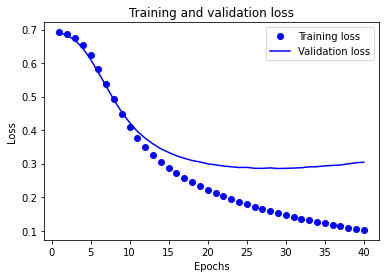

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo' 는 파란색 점 입니다.
plt.plot(epochs, loss, 'bo', label='Training loss')

# 'b'는 파란 실선 입니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

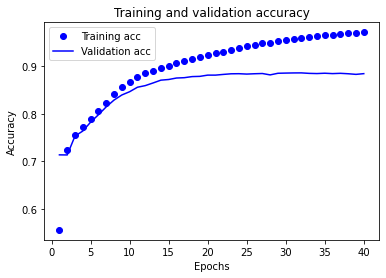

In [22]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 과대적합(overfitting)을 막기 위해 epoch=20에서 훈련을 멈추는 것이 좋을 듯
  - 콜백(callback)을 사용하여 자동으로 멈추게 하는 방법